# Background:

This notebook is an exploratory analysis of High Order Discriminant Analysis (HODA). The reference paper can be found at this link: https://www.jstage.jst.go.jp/article/nolta/1/1/1_1_37/_article . 

High order discriminant analysis (HODA) is especially useful to decompose high dimensional data structure, pattern recognition, and to reduce the risk of overfitting for image segmentation/detection tasks. Reducing the original raw data tensor to a lower dimensional representation is also expected to produce significant time savings for model fitting. In this analysis, an example of the usage of HODA for image classification is illustrated.

### High level overview:
1. Multidimensional tensors are created representing the training data and test data. 
    1. In this task, each train/test tensor is 3-dimensional, with each frontal slice representing each image (128x128). 
    2. The dimension of the train tensor is 128x128x840, where 840 = 20 (number of classes) x 42 (number of training samples per class). 
    3. The dimension of the test tensor is 128x128x600, where 600 = 20 (number of classes) x 30 (number of training samples per class).
   
   
2. Finding the correct classification labels on the test data:
    1. Using the raw train tensor, HODA finds the core train tensor of a lower dimension, along with the set of basis matrices representing its feature space.
    2. The basis matrices found are used along with the raw test tensor to extract its lower dimensional representation (getting the core test tensor).
    3. The core train tensor is reshaped to a sample/feature matrix and used to train a multinomial SVM classifier. 
    4. Test accuracy of the model is reported on the core test tensor, also reshaped to a sample/feature matrix.

In [1]:
### Required packages
import os
import re
import numpy as np
import pandas as pd
import tensorly as tl
import scipy
import random
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
## file path
folder = '### specify path here ###'

## precursors
np.set_printoptions(threshold=np.inf)
random_seed = 188

### sample attributes
num_classes = 20
num_img_per_class = 72
train_per_class = 42
test_per_class = 30

### Data Processing

Some utility functions to read image files and tensor functions. Image files have been stored with naming 'objX_Y.jpg, where X and Y refer to the object number (class) and sample (sample number within class). There are 20 classes, and within each class, 72 samples. The first 42 samples within each class are used for training, while the remaining 30 samples for test. This is done with the assumption that each sample per class are independent and identically distributed.

In [3]:
### return train and test images
def load_files_from_folder(folder):
    img_pattern = r"obj(\d+)_(\d+)\.jpg"
    file_list_train = [0]*(num_classes*train_per_class)
    file_list_test = [0]*(num_classes*test_per_class)
    for filename in os.listdir(folder):
        if filename != '.DS_Store':
            img = plt.imread(os.path.join(folder,filename))
            nummatch = re.match(img_pattern, filename)
            if img is not None:
                x = int(nummatch.group(1))
                y = int(nummatch.group(2))
                if x > num_classes or y > (num_img_per_class-1):
                    raise ValueError
                else:
                    if y < train_per_class:
                        idx = (x-1)*train_per_class + y
                        file_list_train[idx] = img
                    else:
                        idx = (x-1)*test_per_class + (y - train_per_class)
                        file_list_test[idx] = img
    img_dict = {'train':file_list_train,'test':file_list_test}

    return img_dict

### return leading eigenvectors
def find_eig(data,ncomp):
    eigvals, eigvecs = eigh(data)
    sorted_indices = np.argsort(eigvals)
    sorted_indices = sorted_indices[::-1]
    sorted_indices = sorted_indices[:ncomp]
    eigvals_leading = eigvals[sorted_indices]
    eigvecs_leading = eigvecs[:, sorted_indices]
    return eigvals_leading,eigvecs_leading

### convert data to tensors
def create_tensor(tdata):
    for t in range(len(tdata)):
        tensor_temp = tl.tensor(tdata[t])
        tensor_temp = tensor_temp.reshape(tensor_temp.shape[0],tensor_temp.shape[1],1)
        if t == 0:
            return_tensor = tl.copy(tensor_temp)
        else:
            return_tensor = tl.concatenate((return_tensor,tensor_temp),axis=2)
    return return_tensor

### Visualize tensors
def plot_tensor_comparison(tensor1,tensor1_name,tensor2,tensor2_name,threshold):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    mask1 = np.abs(tensor1) > threshold
    ax1.voxels(mask1, facecolors='blue', edgecolors='gray', alpha=0.5)
    ax1.set_title(f'{tensor1_name}. Shape:{tensor1.shape[0]}x{tensor1.shape[1]}x{tensor1.shape[2]}')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    ax2 = fig.add_subplot(122, projection='3d')
    mask2 = np.abs(tensor2) > threshold
    ax2.voxels(mask2, facecolors='green', edgecolors='gray', alpha=0.5)
    ax2.set_title(f'{tensor2_name}. Shape:{tensor2.shape[0]}x{tensor2.shape[1]}x{tensor2.shape[2]}')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    plt.tight_layout()
    plt.show()

### Flatten tensor 
def flatten_tensor(ftensor):
    for f in range(ftensor.shape[2]):
        ftensor_temp = tl.copy(ftensor[:,:,f])
        ftensor_temp = ftensor_temp.reshape((1,ftensor.shape[0]*ftensor.shape[1]))
        if f == 0:
            ftensor_flattened = tl.copy(ftensor_temp)
        else:
            ftensor_flattened = tl.concatenate((ftensor_flattened,ftensor_temp),axis=0) 
    return ftensor_flattened

### Algorithm to implement HODA.

The pseudocode can be found from the linked paper, and is shown below. The objective of the algorithm is to optimize the ratio of the between-cluster to within-cluster scatter matrix to optimize the separation between classes that can be used for the subsequent SVM classifier. The iterative process shares similarities conceptually with clustering algorithms, with the exception of input data being a tensor, instead of matrix/vector. Tensor algebra is utilised to derive the cluster mean, and to compute distance metrics for the within cluster and between cluster scatter matrices.


#### Implementation Notes:
1. A fixed iteration of 10 is used, and validated to be sufficient for convergence.
2. The dimensionality reduction aimed for, is to reduce the 128x128 image to a lower dimensional, 10x10 representation. The resulting core train tensor obtained with HODA is thus 10x10x840 (the raw train tensor is 128x128x840).
3. The basis matrices found, U(n), are then used along with the raw test tensor (128x128x600) to find the lower dimensional core test tensor (10x10x600). This particular portion is covered in the main test section.


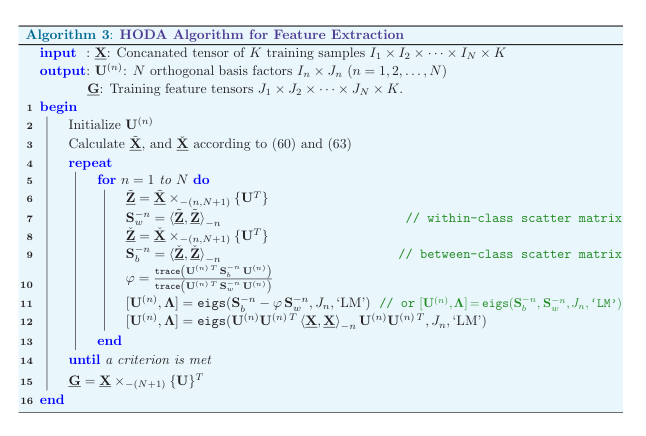


In [4]:
### High Order Discriminant Analysis algorithm (HODA)
def hoda(x_tensor,C,N,J):
    x_tensor_c_mean_list,x_tensor_c_dahd_list = [],[]
    x_tensor_k_tilde_list = []
    x_tensor_avg_all_sample = tl.mean(x_tensor,axis=2)
    mode_list = []
    for m in range(N):
        mode_list.append(m)
    I1,I2,K = x_tensor.shape[0],x_tensor.shape[1],x_tensor.shape[2]
    U1 = np.random.rand(I1,J[0])
    U2 = np.random.rand(I2,J[1])

    U_list = [U1,U2]
    UT_list = [U1.T,U2.T]
    class_len = int(K/C)
    
    for c in range(C):
        x_tensor_c = x_tensor[:,:,c*class_len:(c+1)*class_len]
        x_tensor_c_mean = tl.mean(x_tensor_c,axis=2)
        x_tensor_c_dahd = np.sqrt(class_len)*(x_tensor_c_mean - x_tensor_avg_all_sample)
        x_tensor_c_dahd = x_tensor_c_dahd.reshape(I1,I2,1)
        x_tensor_c_mean_list.append(x_tensor_c_mean)
        x_tensor_c_dahd_list.append(x_tensor_c_dahd)
    for k in range(K):
        ck = int(k/class_len)
        x_tensor_k_tilde = x_tensor[:,:,k] - x_tensor_c_mean_list[ck]
        x_tensor_k_tilde = x_tensor_k_tilde.reshape(I1,I2,1)
        x_tensor_k_tilde_list.append(x_tensor_k_tilde)
    
    x_tensor_tilde_all_sample = tl.concatenate((x_tensor_k_tilde_list),axis=2)
    x_tensor_dahd_all_class = tl.concatenate((x_tensor_c_dahd_list),axis=2)
    trace_ratio_list = []
    for i in range(1,11):
        for n in range(N):
            UT_minusn_list = UT_list.copy()
            del UT_minusn_list[n]
            mode_minusn_list = mode_list.copy()
            del mode_minusn_list[n]
            
            z_tensor_tilde = tl.tenalg.multi_mode_dot(x_tensor_tilde_all_sample,UT_minusn_list,modes=mode_minusn_list)
            z_matrix_tilde_unfold_n = tl.unfold(z_tensor_tilde,mode=(n))
            s_matrix_w = tl.matmul(z_matrix_tilde_unfold_n,z_matrix_tilde_unfold_n.T)
            
            z_tensor_dahd = tl.tenalg.multi_mode_dot(x_tensor_dahd_all_class,UT_minusn_list,modes=mode_minusn_list)
            z_matrix_dahd_unfold_n = tl.unfold(z_tensor_dahd,mode=(n))
            s_matrix_b = tl.matmul(z_matrix_dahd_unfold_n,z_matrix_dahd_unfold_n.T)

            trace_b = tl.trace(tl.matmul(tl.matmul(UT_list[n],s_matrix_b),U_list[n]))
            trace_w = tl.trace(tl.matmul(tl.matmul(UT_list[n],s_matrix_w),U_list[n]))
            trace_ratio = trace_b/trace_w
            
            eig_data_matrix = s_matrix_b - (trace_ratio*s_matrix_w)
            eigvals_j, eigvecs_j = find_eig(eig_data_matrix,J[n])
            U_list[n] = eigvecs_j
            UT_list[n] = eigvecs_j.T
            
            x_matrix_unfold_n = tl.unfold(x_tensor,mode=(n))
            U_matrix_mult = tl.matmul(U_list[n],UT_list[n])
            X_matrix_mult = tl.matmul(x_matrix_unfold_n,x_matrix_unfold_n.T)
            eig_data_matrix = tl.matmul(U_matrix_mult,X_matrix_mult)
            eig_data_matrix = tl.matmul(eig_data_matrix,U_matrix_mult)
            eigvals_j, eigvecs_j = find_eig(eig_data_matrix,J[n])
            U_list[n] = eigvecs_j
            UT_list[n] = eigvecs_j.T    
        trace_ratio_list.append(trace_ratio)
    
    g_tensor = tl.tenalg.multi_mode_dot(x_tensor,UT_list,modes=mode_list)
            
    return g_tensor,U_list,trace_ratio

### SVM classifier function 

RBF kernel is chosen over other kernel options due to its flexibility and precision on non-linear data. Grid search on parameter is done to tune the regularization parameter. 

In [5]:
def svm_classification(xtrain,ytrain,xtest,ytest,print_report):
    parameter_grid = {'C': [0.1, 1, 10, 100,1000],    
                      'kernel': ['rbf']}
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameter_grid, cv=5, scoring='accuracy')
    clf.fit(xtrain, ytrain)
    time_taken = clf.cv_results_['mean_fit_time']
    
    best_clf = clf.best_estimator_
    ypred_svm = best_clf.fit(xtrain, ytrain).predict(xtest)
    score_svm = round(accuracy_score(ypred_svm, ytest)*100,4)
    if print_report == True:
        crp = classification_report(ypred_svm, ytest)
        cm = confusion_matrix(ypred_svm, ytest)
        print(f"Accuracy score: {score_svm} \n")
        print(f"Classification Report: \n")
        print(crp)
        print("\n")
        print(f"Confusion Matrix: \n")
        print(cm)
        print("\n")
        
    return time_taken

###  Main test section

* The section obtains the train and test images, and creates the corresponding raw tensors. 
* SVM is first performed on raw tensors (without decomposition) for benchmarking.
* The function then calls HODA algorithm to decompose the raw train tensor to the lower dimension.
* Finally, the lower dimension test tensor is obtained:
    * To get the representation features for the test dataset, the n-mode product of the originial test tensor with the transpose of the basis matrices of the train dataset. This is because the orthogonal property of the basis matrix means inverse = transpose. 

Sample Images


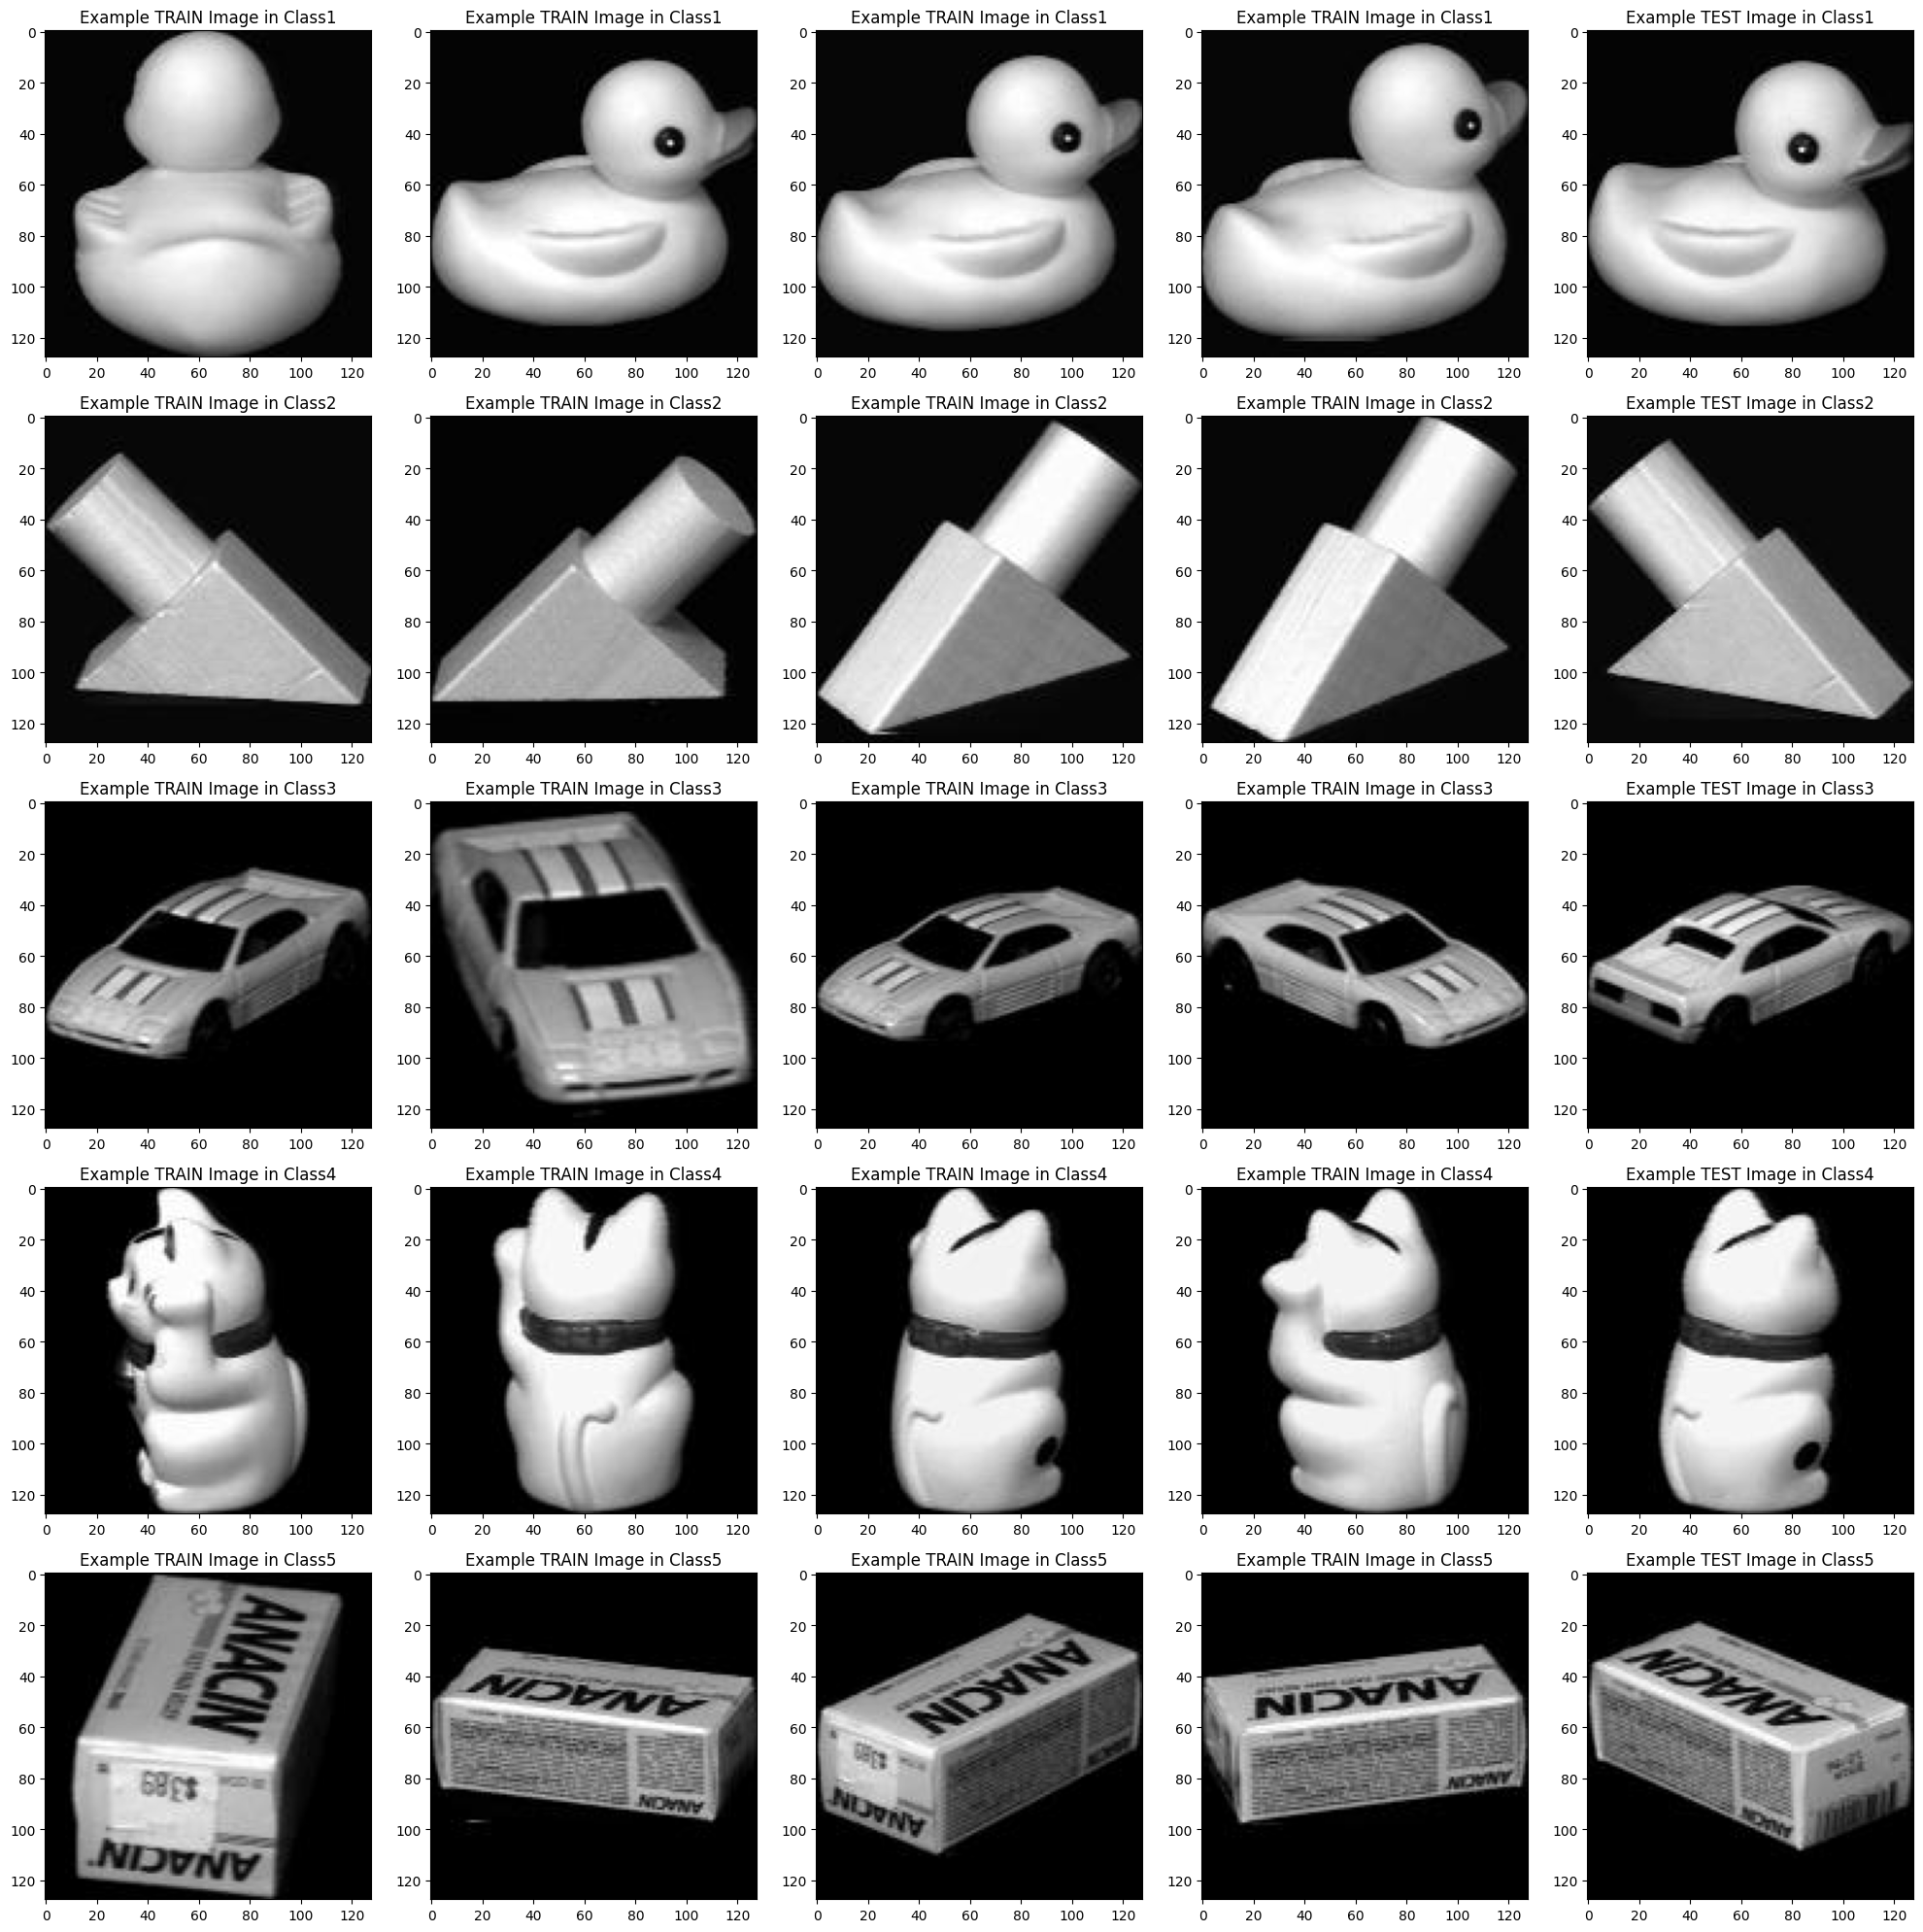

Between/Within cluster ratio found at convergence = 10.860209258598836 



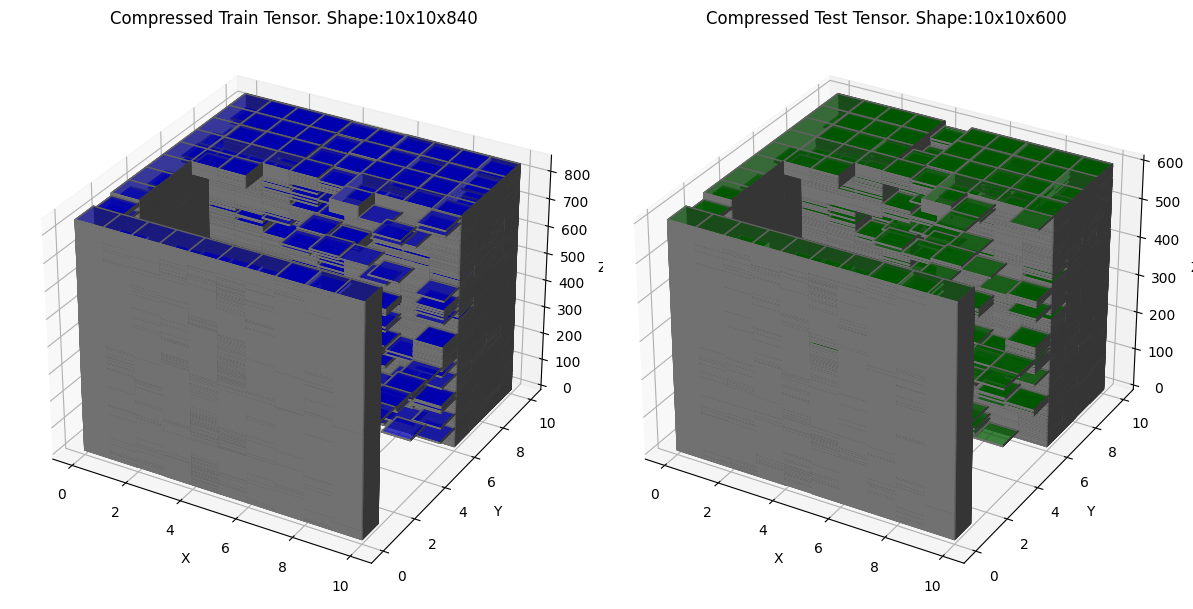

SVM using Low Dimensional Representation
Accuracy score: 97.1667 

Classification Report: 

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        32
           1       0.90      0.93      0.92        29
           2       0.87      1.00      0.93        26
           3       1.00      1.00      1.00        30
           4       0.90      0.93      0.92        29
           5       1.00      0.94      0.97        32
           6       0.97      0.94      0.95        31
           7       1.00      1.00      1.00        30
           8       0.93      0.88      0.90        32
           9       1.00      1.00      1.00        30
          10       1.00      1.00      1.00        30
          11       1.00      1.00      1.00        30
          12       1.00      1.00      1.00        30
          13       1.00      1.00      1.00        30
          14       1.00      1.00      1.00        30
          15       1.00      1.00      1.00

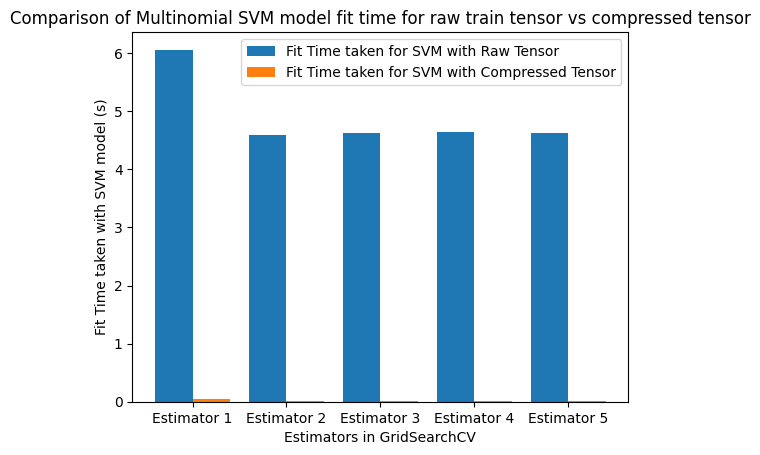

In [6]:
### find basis matrices along image x-y axis (2 dimensional)
folder_attribute = {"C":num_classes,"N":2,"J":[10,10]}

all_data = load_files_from_folder(folder)
train_data = all_data['train']
test_data = all_data['test']
    
### Illustrate some images
print("Sample Images")
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=(20,20))
randint = [random.randint(1, len(test_data)) for _ in range(5)]
for c in range(5):
    for i in range(5):
        if i < 4:
            ax[c][i].imshow(train_data[(c*train_per_class)+i],cmap='gray')
            ax[c][i].set_title(f"Example TRAIN Image in Class{c+1}")
        else:
            ax[c][i].imshow(test_data[(c*test_per_class)+i],cmap='gray')
            ax[c][i].set_title(f"Example TEST Image in Class{c+1}")
plt.tight_layout()
plt.show()
    
train_tensor = create_tensor(train_data)
test_tensor = create_tensor(test_data)
#plot_tensor_comparison(train_tensor,"Raw Train Tensor",test_tensor,"Raw Test Tensor",10)
   
xtrain_raw = flatten_tensor(train_tensor)
xtest_raw = flatten_tensor(test_tensor)


ytrain = [int((i-1)/train_per_class) for i in range(1,(841))]
ytest = [int((i-1)/test_per_class) for i in range(1,601)]
    
ref_tt = svm_classification(xtrain_raw,ytrain,xtest_raw,ytest,print_report=False)
            
core_tensor_result_train,basis_matrix_result_train,trace_ratio_result_train = hoda(train_tensor,folder_attribute["C"],folder_attribute["N"],folder_attribute["J"])
print(f"Between/Within cluster ratio found at convergence = {trace_ratio_result_train} \n")
    
for mode, u in enumerate(basis_matrix_result_train):
    if mode == 0:
        core_tensor_result_test = tl.tenalg.mode_dot(test_tensor, u.T, mode)
    else:
        core_tensor_result_test = tl.tenalg.mode_dot(core_tensor_result_test, u.T, mode)
            
plot_tensor_comparison(core_tensor_result_train,"Compressed Train Tensor",core_tensor_result_test,"Compressed Test Tensor",10)
    
xtrain = flatten_tensor(core_tensor_result_train)
xtest = flatten_tensor(core_tensor_result_test)

print("SVM using Low Dimensional Representation")
hoda_tt = svm_classification(xtrain,ytrain,xtest,ytest,print_report=True)

xaxis_labels = [f'Estimator {i+1}' for i in range(5)]
xaxis = range(len(xaxis_labels))
plt.bar([i - 0.2 for i in xaxis], ref_tt, width=0.4, label='Fit Time taken for SVM with Raw Tensor', align='center')
plt.bar([i for i in xaxis], hoda_tt, width=0.4, label='Fit Time taken for SVM with Compressed Tensor', align='edge')
plt.xlabel('Estimators in GridSearchCV')
plt.ylabel('Fit Time taken with SVM model (s)')
plt.title('Comparison of Multinomial SVM model fit time for raw train tensor vs compressed tensor')
plt.xticks(xaxis, xaxis_labels)
plt.legend()
plt.show()

# Summary

It can be seen, first and foremost, that HODA decomposes the raw train tensor from a dimension of 128x128x840 to 10x10x840. At convergence, the between-class/within class scatter matrix ratio (across multiple runs) is noted to be > 8, indicative of separation achieved. The SVM classifier with RBF kernel performs relatively well, with an accuracy exceeding 97%. The reduction in model fitting time with the compressed tensor to a fraction of the case when raw tensor is used is a significant plus, and will help mitigate bottlenecks for hyperparameter tuning for large datasets in large scale applications.